In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from sklearn.decomposition import PCA
from src.feature_extraction import scale_density, split_data, coarsen_density
from src.cluster_data import *
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import plotly.express as px
import yaml

In [2]:
def compute_oos_and_partition(coarseness):
    ## Load, Split, Scale data
    density = np.load("../data/dataset1/density.npy", allow_pickle=True)
    coarse_resolution = (200//coarseness)**2
    coarse_density = np.empty((1210, coarse_resolution))
    for i, v in enumerate(density):
        v = v.reshape(200,200)
        coarse_v = coarsen_density(v, I = 200, h = 1000/(199.0), bin_size = coarseness)
        coarse_density[i] = coarse_v
    
    
    density_train, density_test = split_data(coarse_density, itr_cutoff = 5)
    
    
    density_train = scale_density(density_train).reshape((605,coarse_resolution))
    density_test = scale_density(density_test).reshape((605,coarse_resolution))
    
    
    ## Reduce dimensions to 3
    density_pca = PCA(n_components = 3, random_state = 0)
    density_pca.fit(density_train)
    density_train_reduced = density_pca.transform(density_train)
    density_test_reduced = density_pca.transform(density_test)
    var = density_pca.explained_variance_ratio_
    print(f"Cell Density ({coarseness}x{coarseness} bins): Cumulative Explained Variance = {100*np.sum(var[:3]):.2f}%")
    
    
    
    # Cluster
    density_kmeans = KMeans(n_clusters = 4,n_init = 'auto', random_state = 0)
        
    density_kmeans.fit(density_train_reduced)
    density_train_labels = density_kmeans.predict(density_train_reduced)
    density_predicted_test_labels = density_kmeans.predict(density_test_reduced)
    
    print(np.bincount(density_train_labels))
    
    pca_fig = px.scatter_3d(x=density_train_reduced[:, 0],
                            y=density_train_reduced[:, 1],
                            z=density_train_reduced[:, 2],
                            color=density_train_labels, labels = {'x': f"(x) {100*var[0]:.2f}% variance",
                                                                  'y': f"(y) {100*var[1]:.2f}% variance",
                                                                  'z':f"(z) {100*var[2]:.2f}% variance"},
                            title = f"Cell Density ({coarseness}x{coarseness} bins)")
    
    pca_fig.update_traces(marker={'size': 4})
    pca_fig.update_layout(autosize=False,
                                 width = 1200,
                                 height = 1000)
         
    pca_fig.show()
    
    
    
    
    
    
    
    
    param_ranges = {"(c_a,eta1)" : np.array([()])}
        
    c_a_base = 0.4
    eta1_base = 5
    num_clusters = 4
        
    param_labels, _ = generate_param_labels(param_ranges, labels = {'(c_a,eta1)' : density_train_labels.reshape((121,5))}, n_iterations = 5, n_param_value_combos = 121)
    common_label = param_labels['(c_a,eta1)'].reshape((11,11))
    eta1_vec = np.round(np.logspace(np.log10(eta1_base / 2), np.log10(2 * eta1_base), 11),3)
    c_a_vec = np.round(np.logspace(np.log10(c_a_base / 2), np.log10(2 * c_a_base), 11),3)
        
    C_A,ETA_1 = np.meshgrid(np.unique(c_a_vec),np.unique(eta1_vec))
        
    c_a_mean = np.zeros((num_clusters,))
    for i in np.arange(num_clusters):
        c_a_mean[i] = np.mean(C_A[common_label==i])
        
    common_label_copy = np.zeros(C_A.shape)
        
    for iold, inew in enumerate(np.argsort(c_a_mean)):
        common_label_copy[common_label == inew] = iold
            
        
    common_label_copy = common_label_copy.reshape(121)
    common_label = common_label.reshape(121)
        
    relabel = np.zeros(num_clusters)
    for iold in range(num_clusters):
        # For each of the old cluster assignments, lookup where they were reassigned in common_label_copy
        relabel[iold] = common_label_copy[np.where(common_label == iold)[0][0]]
    
    oos = accuracy_score(np.repeat(param_labels['(c_a,eta1)'], 5), density_predicted_test_labels)
    
    
    
    cm = generate_confusion_matrix(np.repeat(param_labels['(c_a,eta1)'], 5), density_predicted_test_labels, n_clusters = 4)
    cm_fig = plot_confusion_matrix_and_OOS(confusion_matrix = cm,
                                           y_true = np.repeat(param_labels['(c_a,eta1)'], 5),
                                           y_pred = density_predicted_test_labels,
                                           n_clusters = 4,
                                           xlabel = "Group predicted by k-means",
                                           ylabel = "Group based on true value of $(c_a, \eta_1)$",
                                           title = f"Cell Density ({coarseness}x{coarseness} bins) Confusion Matrix");   
    
    
    
    cm_fig.savefig(f"../figures/density_coarseness={coarseness}_confusion_matrix.png")
    heat_fig = plt.figure(figsize = (14, 12))
    
    col1 = np.repeat(c_a_vec,11)
    col2 = np.tile(eta1_vec,11)
    
    
    d = {'c_a': col1, 'eta1': col2, 'Cluster': common_label_copy}
    df = pd.DataFrame(data=d)
    piv_df = df.pivot(index='c_a', columns='eta1', values='Cluster')
    
    plasma = mpl.colormaps['plasma'].resampled(num_clusters)
    
    
    tick_inds = [i for i in range(len(c_a_vec))]
    tick_inds = tick_inds[::2]
    tick_inds.append(5)
        
    heat_ax = heat_fig.add_subplot(111)
    plt.rcParams.update({'font.size': 15})
    sns.heatmap(piv_df, cmap = plasma, ax = heat_ax, cbar_kws={'ticks': [i for i in range(num_clusters)]})
    heat_ax.set_yticks(heat_ax.get_yticks()[tick_inds])
    heat_ax.set_xticks(heat_ax.get_xticks()[tick_inds])
    heat_ax.set_yticklabels(c_a_vec[tick_inds],rotation = 0, fontsize = 15)
    heat_ax.set_xticklabels(eta1_vec[tick_inds],rotation = 0, fontsize = 15)
    heat_ax.invert_yaxis()
    heat_ax.set_title(f"Cell Density ({coarseness}x{coarseness} Bins)", fontsize = 30)
    heat_ax.set_xlabel("Hill Arrest Index ($\eta_1$)",fontsize=18)
    heat_ax.set_ylabel("Critical Arrest Concentration ($c_a$)",fontsize=18)
    heat_fig.tight_layout()
    heat_fig.savefig(f"../figures/density_coarseness={coarseness}_parameter_partition.png")
    return

# **2x2 Bin Size**

Cell Density (2x2 bins): Cumulative Explained Variance = 13.32%
[238 115 147 105]


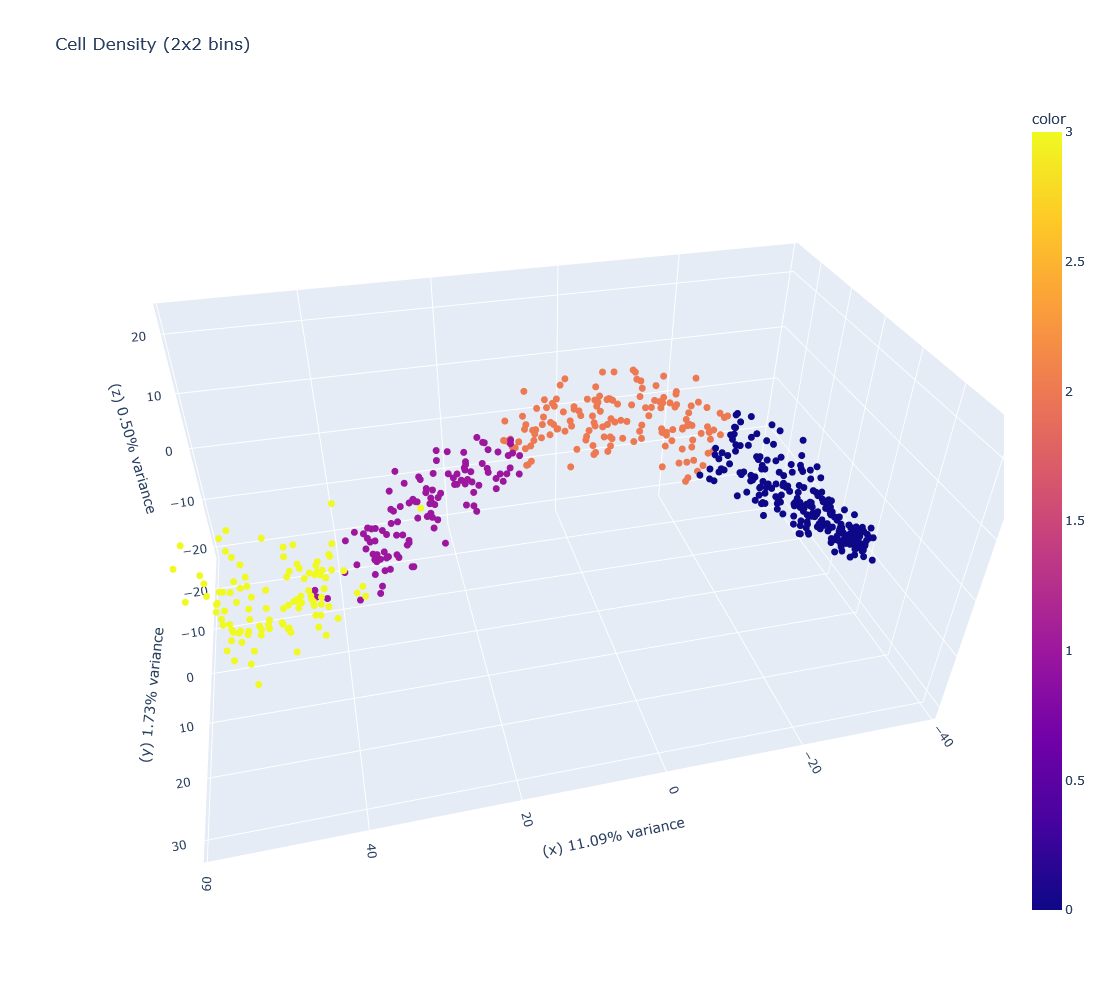

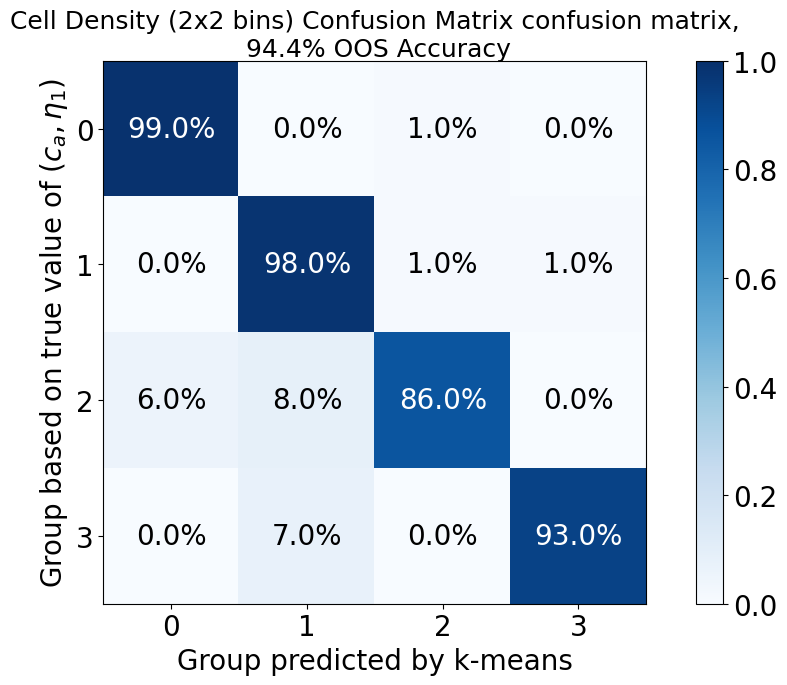

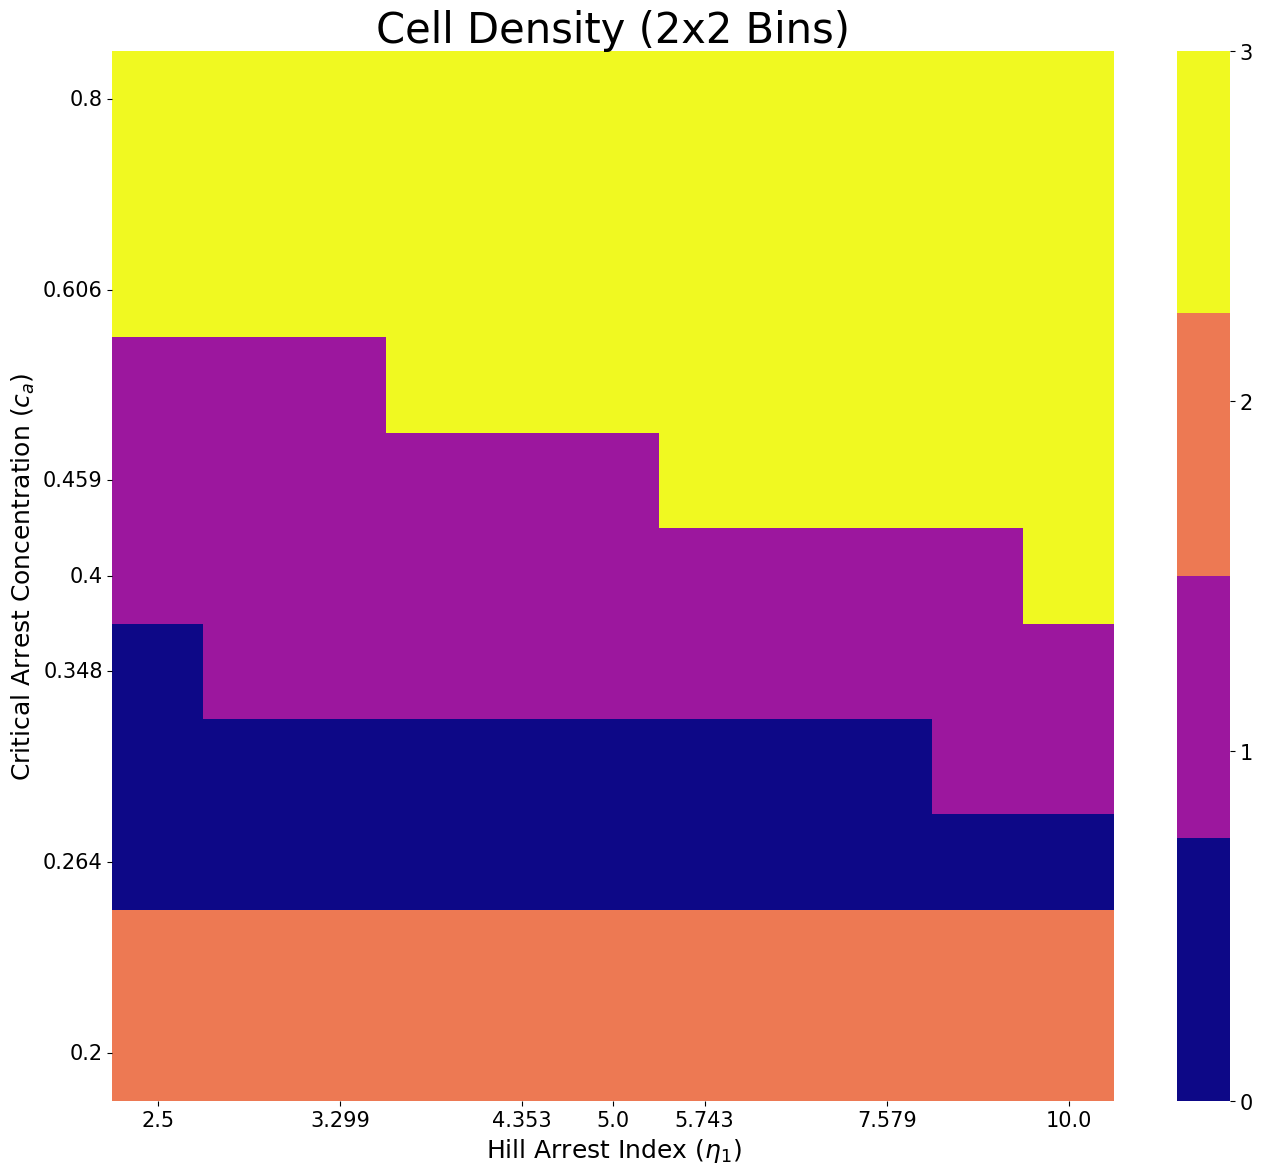

In [3]:
compute_oos_and_partition(2)

#

# **4x4 Bin Size**

Cell Density (4x4 bins): Cumulative Explained Variance = 51.53%
[219 127 152 107]


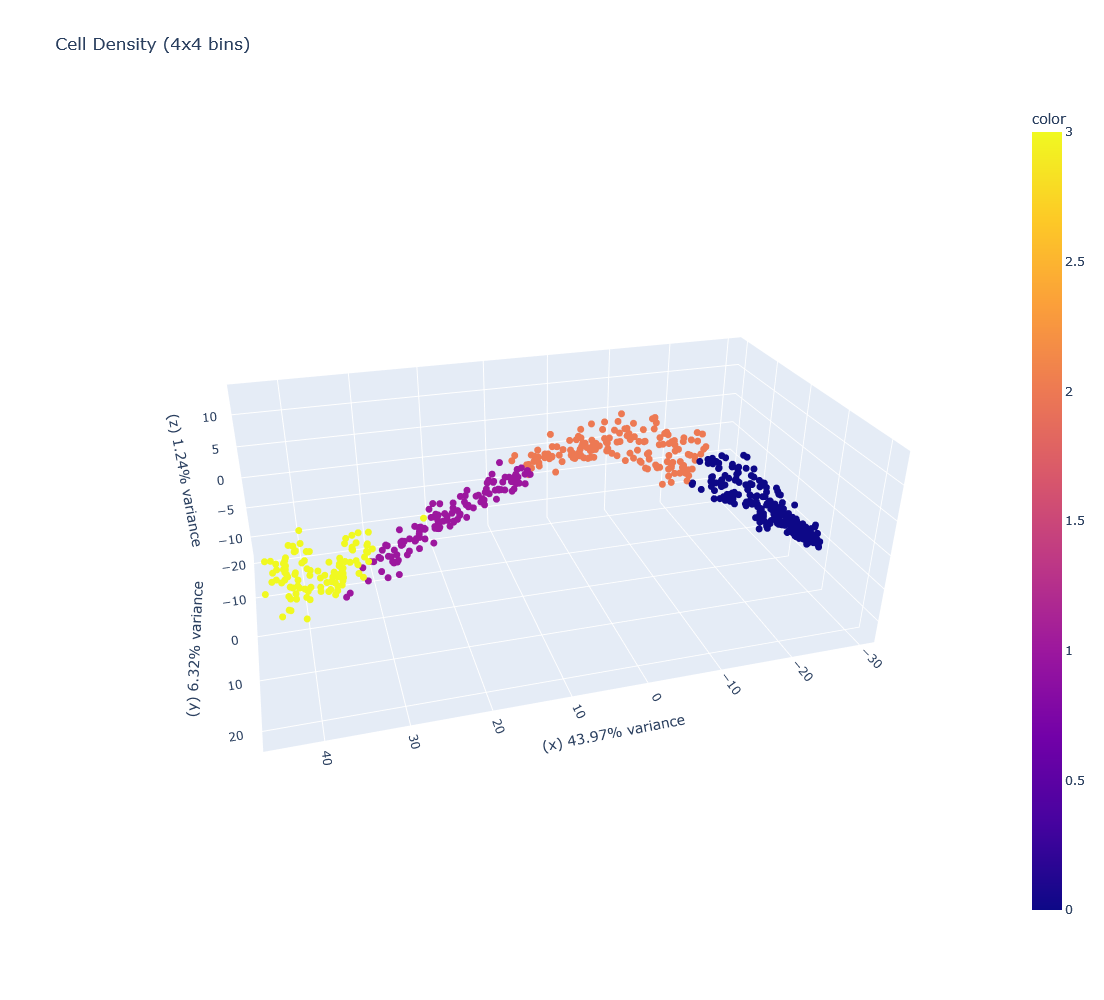

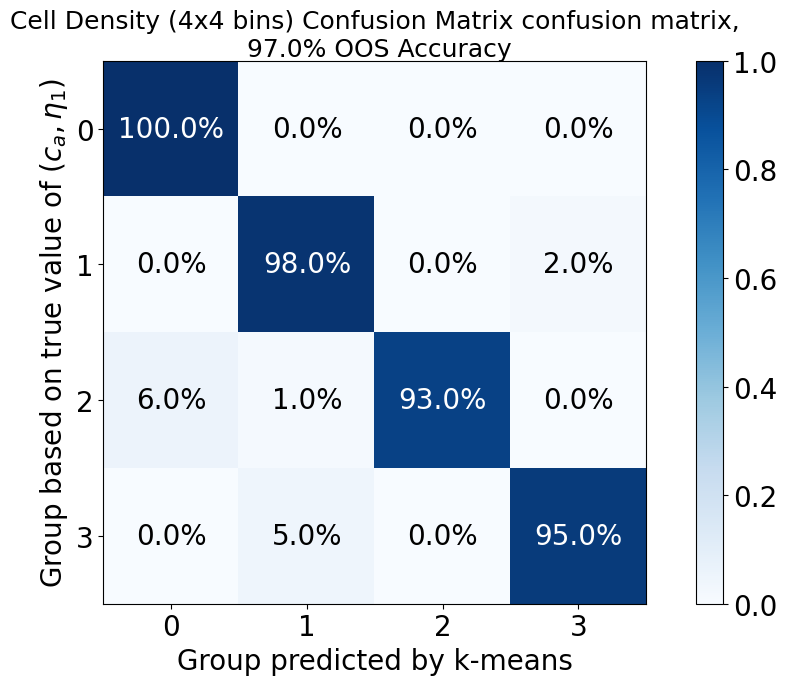

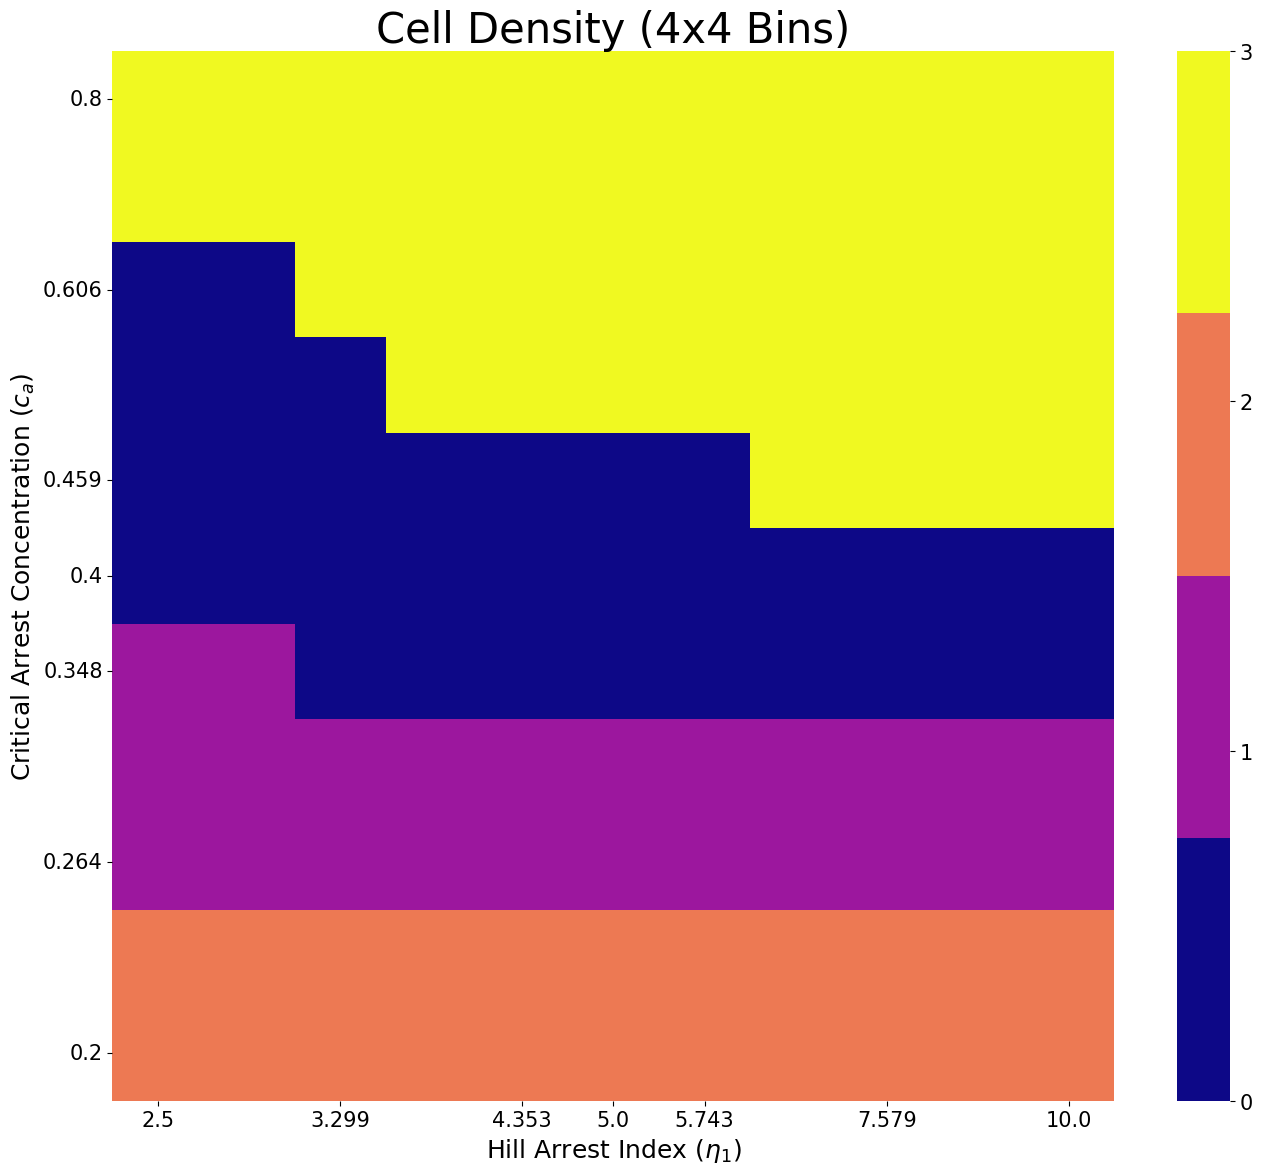

In [4]:
compute_oos_and_partition(4)

# **8x8 Bin Size**

Cell Density (8x8 bins): Cumulative Explained Variance = 75.96%
[222 124 150 109]


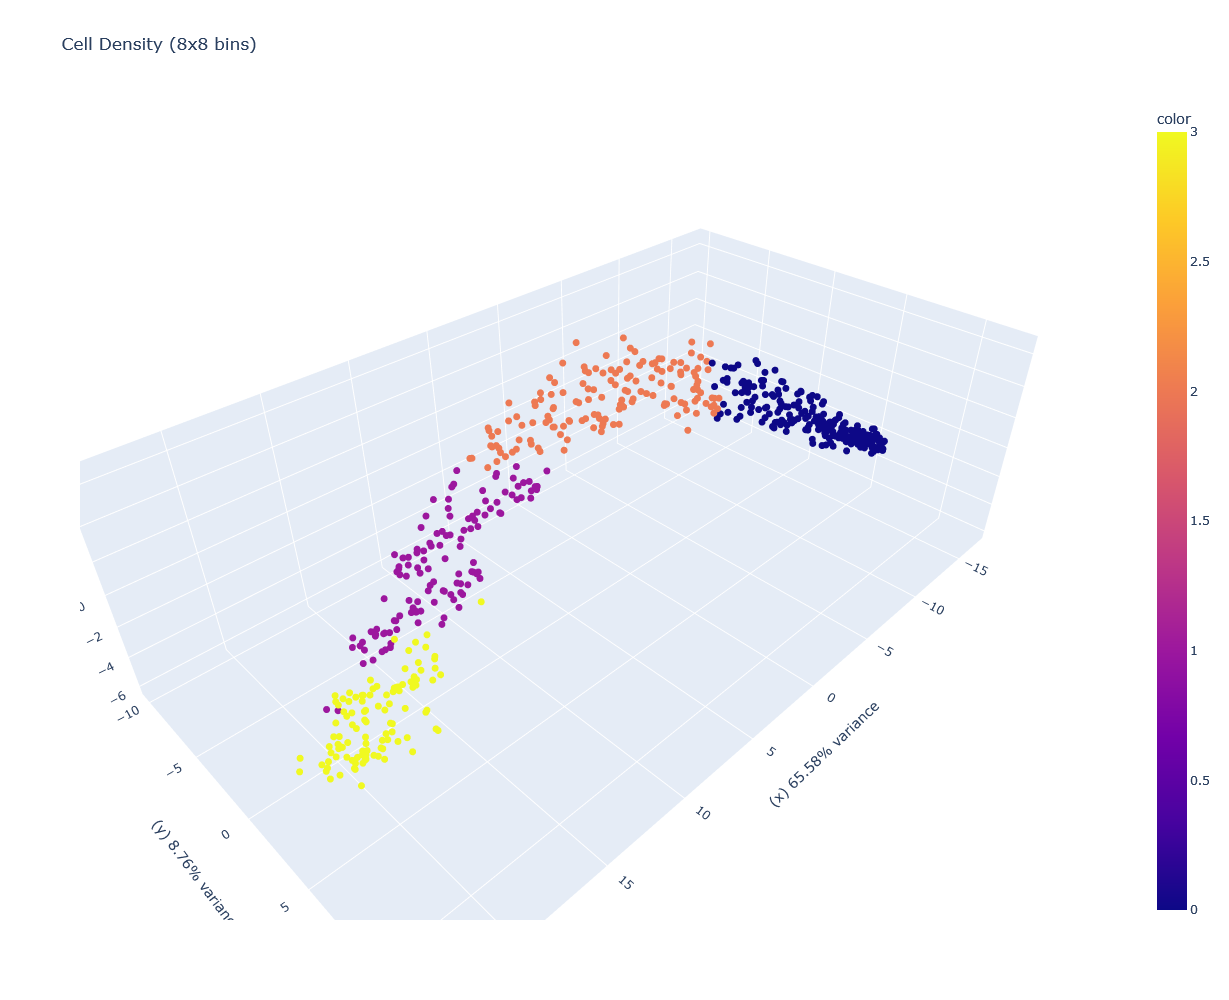

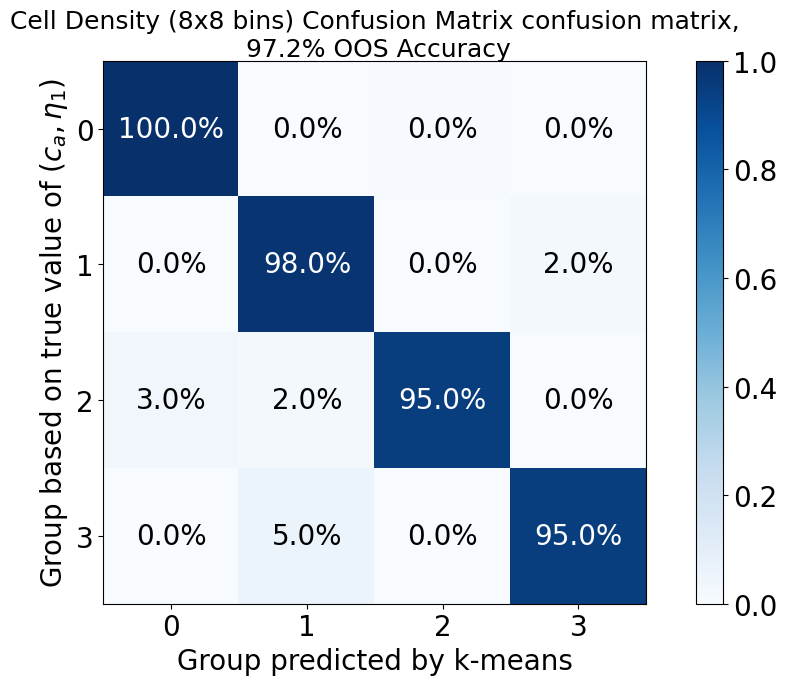

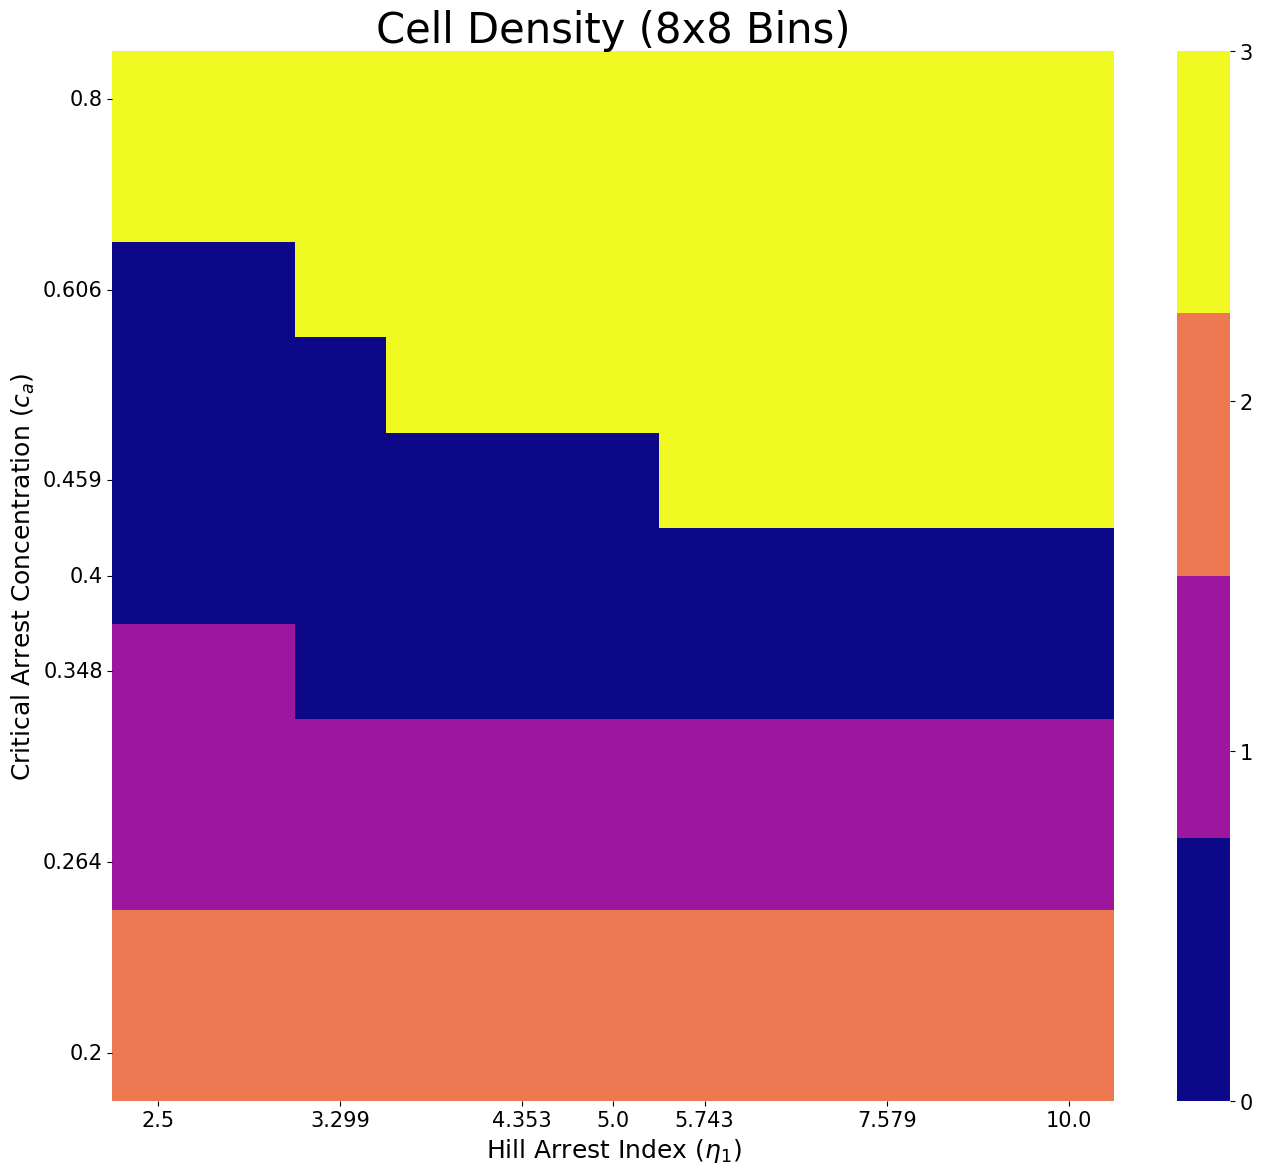

In [5]:
compute_oos_and_partition(8)

# **20x20 Bin Size**

Cell Density (20x20 bins): Cumulative Explained Variance = 91.93%
[214 134 138 119]


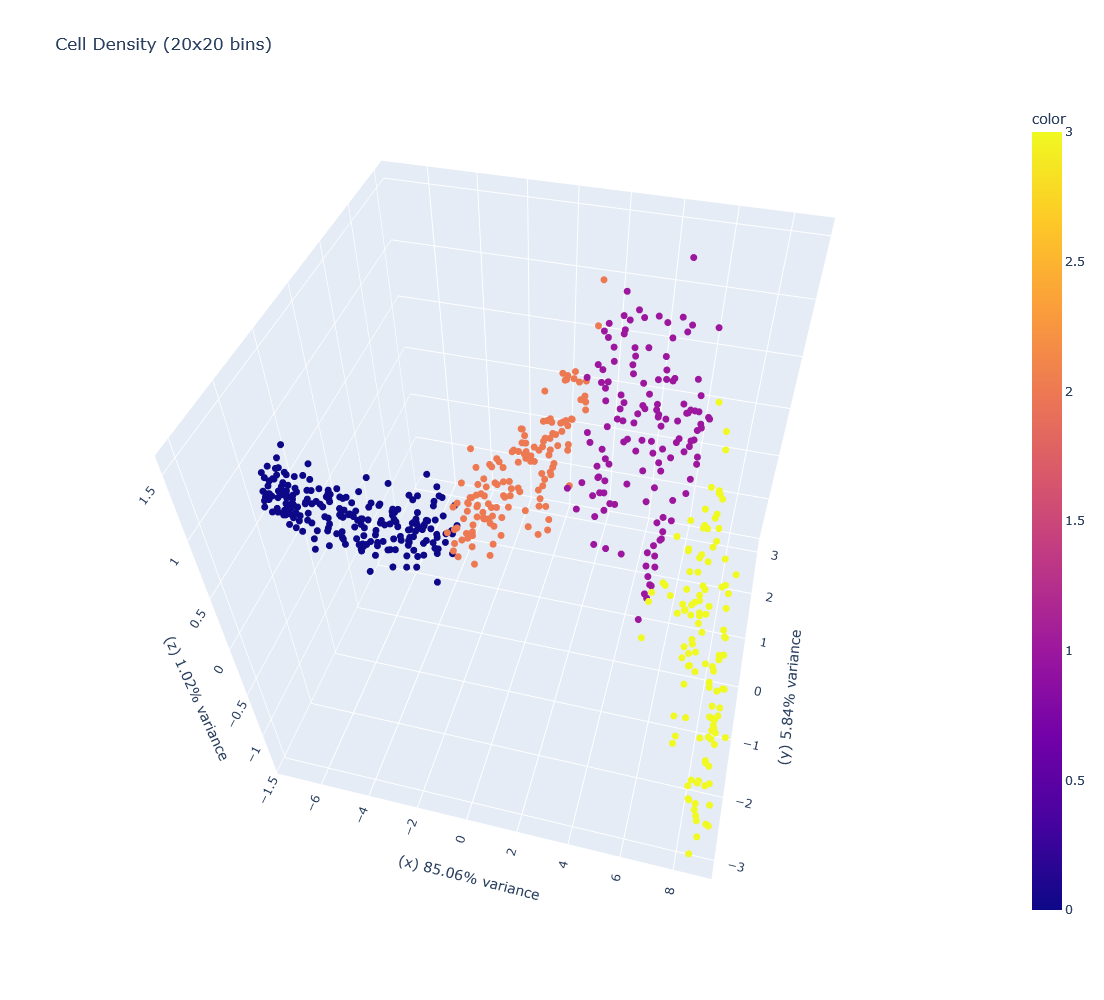

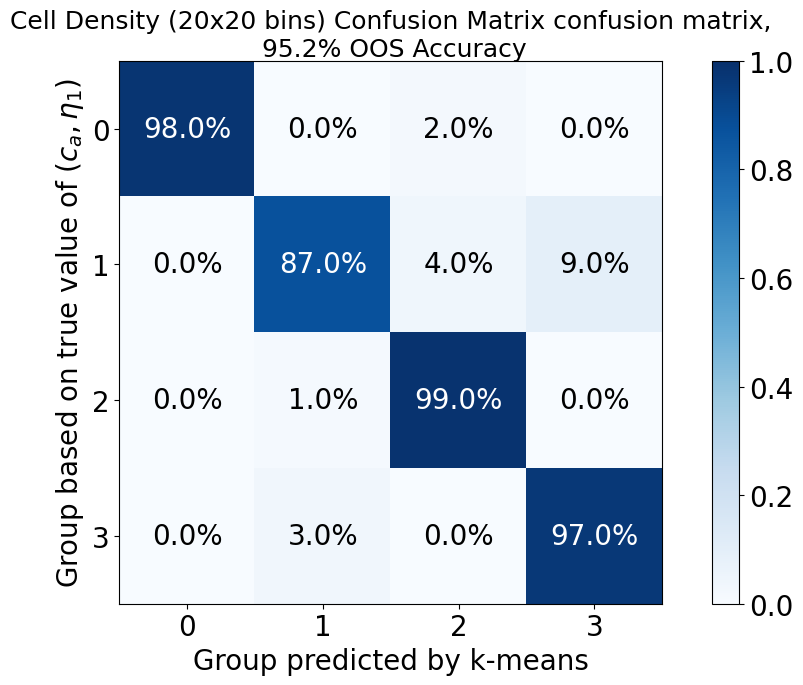

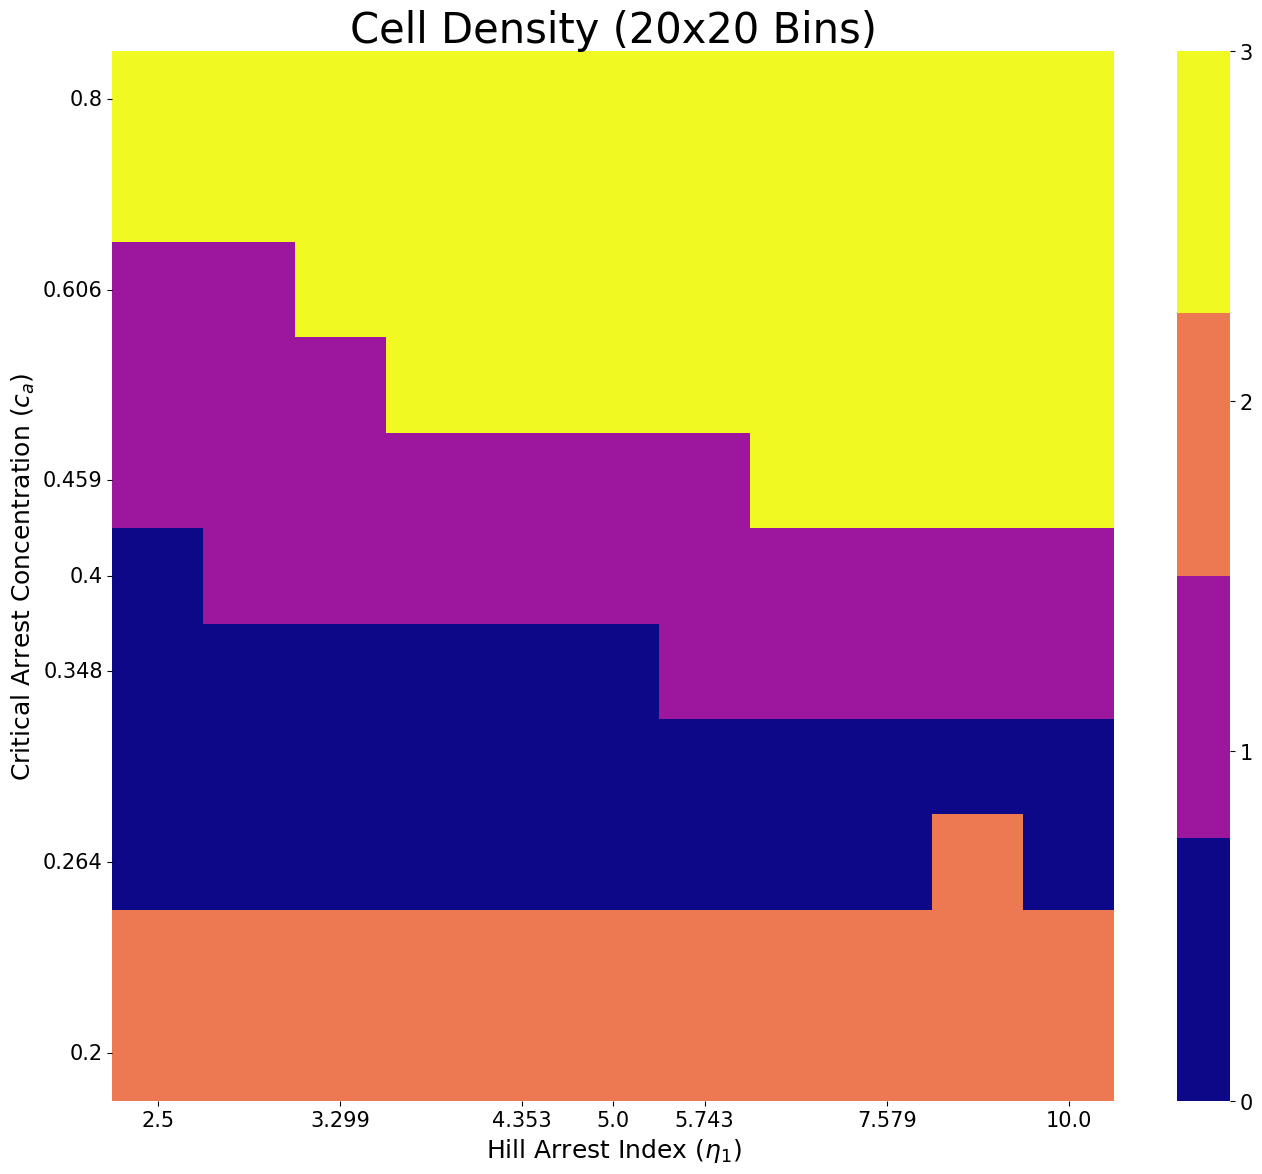

In [6]:
compute_oos_and_partition(20)

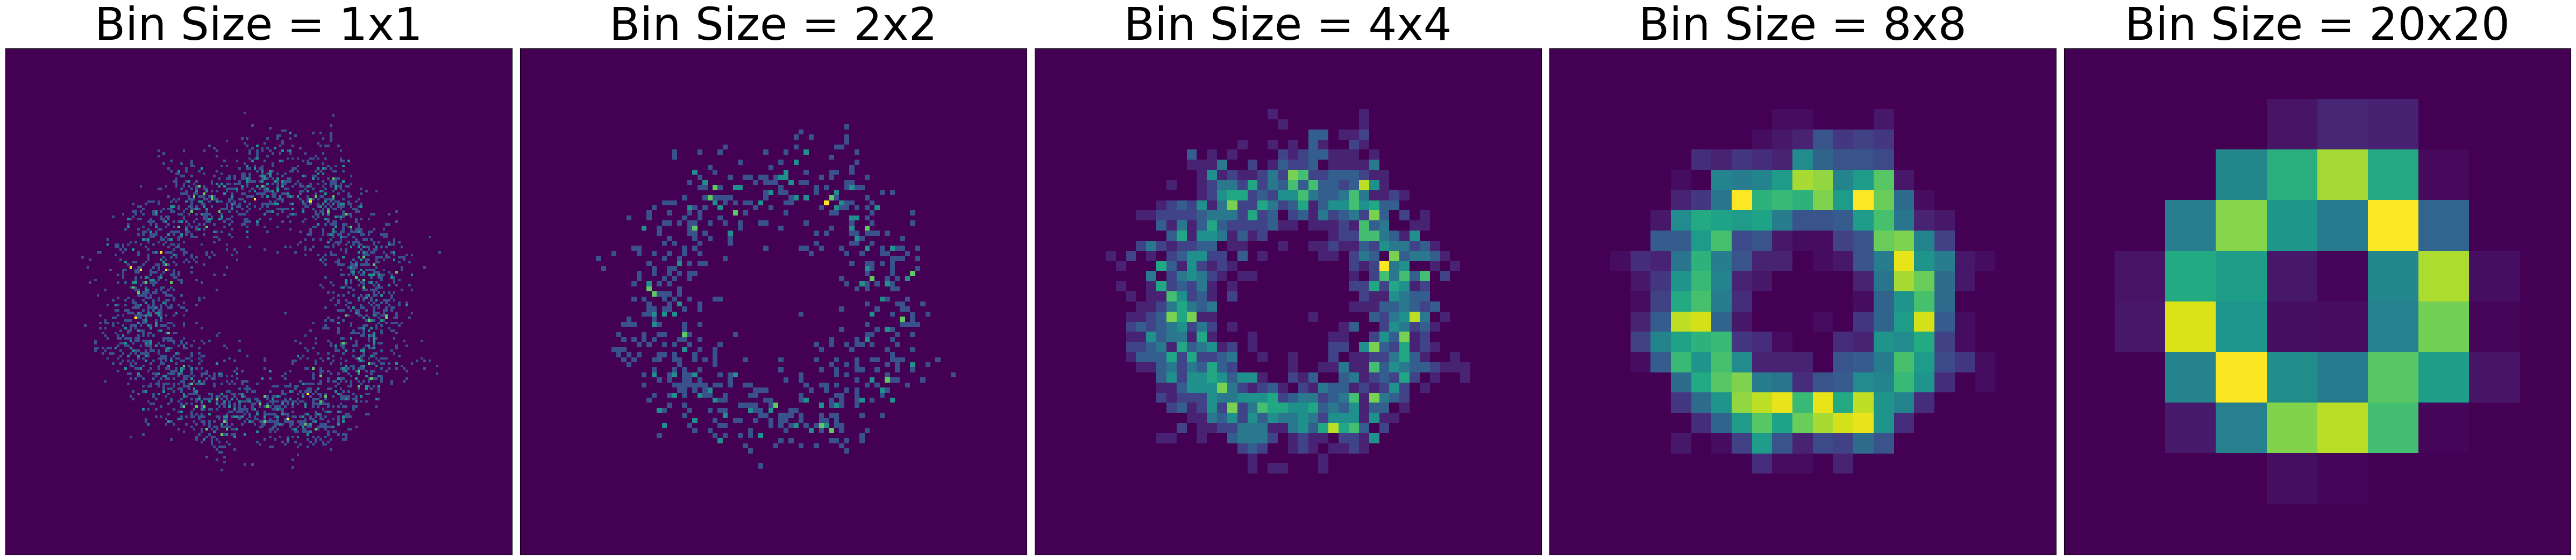

In [9]:
out = np.load("../data/abm2d_base_params.npz", allow_pickle=True)
v = out['v'].reshape((200,200))
fig, ax  = plt.subplots(1,5, figsize=(48,16))
fontsize = 20
for i, coarseness in enumerate([1,2,4,8,20]):
    coarse_resolution = (200//coarseness)
    coarse_v = coarsen_density(v, I = 200, h = 1000/(199.0), bin_size = coarseness).reshape((coarse_resolution,coarse_resolution))
    ax[i].imshow(coarse_v)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Bin Size = {coarseness}x{coarseness}",fontsize=3*fontsize)
fig.tight_layout()
fig.savefig(f"../figures/coarse_density_plot.png")